
=== Gradient Boosting Evaluation with Sampling Methods ===

--- No Sampling ---
Best Params  : {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1}
Best Thresh  : 0.1173
Accuracy     : 0.8517
Recall       : 0.4119
Precision    : 0.1952
F1 Score     : 0.2649



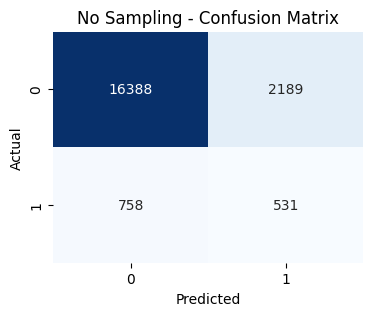

--- Random Oversampling ---
Best Params  : {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1}
Best Thresh  : 0.6811
Accuracy     : 0.8737
Recall       : 0.3375
Precision    : 0.2081
F1 Score     : 0.2575



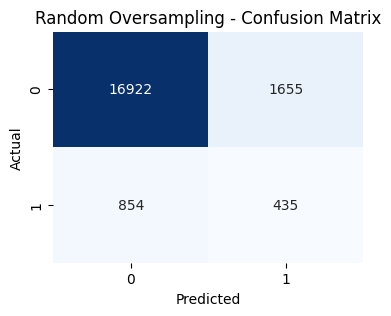

--- Random Undersampling ---
Best Params  : {'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1}
Best Thresh  : 0.6644
Accuracy     : 0.8460
Recall       : 0.4065
Precision    : 0.1859
F1 Score     : 0.2551



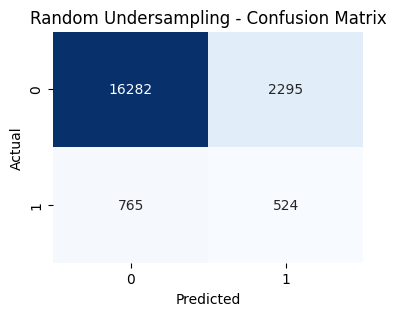

--- SMOTE ---
Best Params  : {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.05}
Best Thresh  : 0.4820
Accuracy     : 0.8852
Recall       : 0.2537
Precision    : 0.1988
F1 Score     : 0.2229



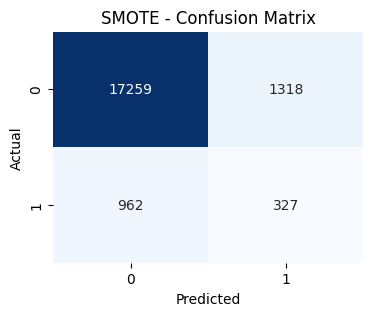


Best sampling method based on F1 Score: **No Sampling**
F1 Score: 0.2649


In [9]:

import warnings
warnings.filterwarnings("ignore")  # Suppress warnings


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, precision_recall_curve, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# 1. Load data
# ==============================
#df = pd.read_csv("/content/drive/MyDrive/fyp/data/new_dataset.csv")
df = pd.read_csv("C:/Users/ASUS/Desktop/FYP/Data Set/cleaned_data.csv")

target_column = "CONTRACT_STATUS"

y = df[target_column]
X = df.drop(columns=[target_column])

# ==============================
# 2. Train/test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ==============================
# 3. Encode categorical columns
# ==============================
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
X_train = pd.get_dummies(X_train, columns=categorical_features, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_features, drop_first=True)
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# ==============================
# 4. Sampling methods
# ==============================
sampling_methods = {
    "No Sampling": None,
    "Random Oversampling": RandomOverSampler(random_state=42),
    "Random Undersampling": RandomUnderSampler(random_state=42),
    "SMOTE": SMOTE(random_state=42)
}

# ==============================
# 5. Reduced Hyperparameter Grid for Speed
# ==============================
param_dist = {
    "classifier__n_estimators": [100, 150, 200],
    "classifier__learning_rate": [0.05, 0.1],
    "classifier__max_depth": [3, 4],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__subsample": [0.8, 1.0]
}

# ==============================
# 6. Stratified K-Fold CV (reduced to 3 folds for speed)
# ==============================
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = {}

print("\n=== Gradient Boosting Evaluation with Sampling Methods ===\n")

for sampling_name, sampler in sampling_methods.items():
    print(f"--- {sampling_name} ---")

    if sampler:
        pipeline = ImbPipeline([
            ("sampler", sampler),
            ("classifier", GradientBoostingClassifier(random_state=42))
        ])
    else:
        pipeline = ImbPipeline([
            ("classifier", GradientBoostingClassifier(random_state=42))
        ])

    # RandomizedSearchCV instead of full GridSearch
    search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_dist,
        n_iter=15,  # only test 15 random combinations
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )
    search.fit(X_train, y_train)
    best_pipeline = search.best_estimator_

    # ==============================
    # Threshold tuning
    # ==============================
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

    y_pred = (y_prob >= best_threshold).astype(int)

    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Nicely formatted output
    print(f"Best Params  : {search.best_params_}")
    print(f"Best Thresh  : {best_threshold:.4f}")
    print(f"Accuracy     : {accuracy:.4f}")
    print(f"Recall       : {recall:.4f}")
    print(f"Precision    : {precision:.4f}")
    print(f"F1 Score     : {f1:.4f}\n")

    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{sampling_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    results[sampling_name] = {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        "best_threshold": best_threshold,
        "best_pipeline": best_pipeline
    }

# ==============================
# Pick best method
# ==============================
best_method = max(results, key=lambda k: results[k]["f1"])
print(f"\nBest sampling method based on F1 Score: **{best_method}**")
print(f"F1 Score: {results[best_method]['f1']:.4f}")


In [11]:
import joblib

# ==============================
# 7. Save the model 
# ==============================

best_pipeline = results[best_method]['best_pipeline']
joblib.dump(best_pipeline, 'fyp-gradientboost.pkl')
print("Model saved successfully as 'gradient_boost_model.pkl'")

Model saved successfully as 'gradient_boost_model.pkl'
